In [30]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Load data and set labels
df = pd.read_excel('sentence_sentiment_label.xlsx')

df = df[['Sentence','label']].drop_duplicates()

df['label_new'] = df['label'].map({'Positive':2,'Negative':0,'Neutral':1})

In [33]:
import nltk
# Uncomment to download "stopwords"
#nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [34]:
from sklearn.model_selection import train_test_split

df['text'] = df['Sentence'].apply(lambda x:text_preprocessing(x))

X = df.text.values
y = df.label_new.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=0)

import torch
device = torch.device("cpu")

In [38]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [39]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [40]:
train_input_ids, train_att_masks = encode(X_train.tolist())
valid_input_ids, valid_att_masks = encode(X_val.tolist())

In [41]:
import torch
train_y = torch.LongTensor(y_train.tolist())
valid_y = torch.LongTensor(y_val.tolist())

In [42]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [43]:
from transformers import BertForSequenceClassification
N_labels = len(set(y_train))
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [49]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 100
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [50]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(X_train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(X_val) / BATCH_SIZE), valid_loss / (step_num_e + 1)))


Epoch:  1


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.5811984886725744 
3/3 val loss: 0.7949833671251932 
Epoch:  2


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.5466992283860842 
3/3 val loss: 0.784485916296641 
Epoch:  3


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.5416797151168188 
3/3 val loss: 0.7846433917681376 
Epoch:  4


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.5280052497982979 
3/3 val loss: 0.7808904051780701 
Epoch:  5


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.5152489120761553 
3/3 val loss: 0.7778234879175822 
Epoch:  6


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.4997536540031433 
3/3 val loss: 0.7891923387845358 
Epoch:  7


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.4992193380991618 
3/3 val loss: 0.7644386688868204 
Epoch:  8


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.4758772800366084 
3/3 val loss: 0.7627718846003214 
Epoch:  9


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.4390532225370407 
3/3 val loss: 0.7809679706891378 
Epoch:  10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.44068290293216705 
3/3 val loss: 0.7729595104853312 
Epoch:  11


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.4283161759376526 
3/3 val loss: 0.7550904353459676 
Epoch:  12


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.4149882619579633 
3/3 val loss: 0.7494366963704427 
Epoch:  13


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.40336401512225467 
3/3 val loss: 0.7548412283261617 
Epoch:  14


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.38700662304957706 
3/3 val loss: 0.7526552677154541 
Epoch:  15


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.3726065047085285 
3/3 val loss: 0.7340841492017111 
Epoch:  16


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.3515034231046836 
3/3 val loss: 0.7338186701138815 
Epoch:  17


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.34966623162229854 
3/3 val loss: 0.7397727171579996 
Epoch:  18


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.3461490807433923 
3/3 val loss: 0.7426304221153259 
Epoch:  19


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.3354371873040994 
3/3 val loss: 0.7356061140696207 
Epoch:  20


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.3152139124770959 
3/3 val loss: 0.7186756730079651 
Epoch:  21


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.30902733529607457 
3/3 val loss: 0.7355595628420512 
Epoch:  22


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.2954504229128361 
3/3 val loss: 0.7175712386767069 
Epoch:  23


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.28139348948995274 
3/3 val loss: 0.7092947562535604 
Epoch:  24


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.2792150390644868 
3/3 val loss: 0.7212641437848409 
Epoch:  25


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.26746880635619164 
3/3 val loss: 0.7348271409670512 
Epoch:  26


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.2719736422101657 
3/3 val loss: 0.7354825139045715 
Epoch:  27


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.2531387209892273 
3/3 val loss: 0.6924193302790324 
Epoch:  28


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.24416228259603182 
3/3 val loss: 0.7228366533915201 
Epoch:  29


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.24241621233522892 
3/3 val loss: 0.7212671438852946 
Epoch:  30


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.2323347938557466 
3/3 val loss: 0.6938047011693319 
Epoch:  31


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.21344457318385443 
3/3 val loss: 0.6954205830891927 
Epoch:  32


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.20753630250692368 
3/3 val loss: 0.6822464863459269 
Epoch:  33


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.2068114367624124 
3/3 val loss: 0.7236085732777914 
Epoch:  34


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.1925732928017775 
3/3 val loss: 0.6854528188705444 
Epoch:  35


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.19554180341462293 
3/3 val loss: 0.670478085676829 
Epoch:  36


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.1855021771043539 
3/3 val loss: 0.7122196753819784 
Epoch:  37


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.18757383525371552 
3/3 val loss: 0.7008457183837891 
Epoch:  38


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.1805325032522281 
3/3 val loss: 0.7070926030476888 
Epoch:  39


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.1752905771136284 
3/3 val loss: 0.6533020536104838 
Epoch:  40


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.1640886745105187 
3/3 val loss: 0.6882575949033102 
Epoch:  41


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.15873113150397936 
3/3 val loss: 0.6880707939465841 
Epoch:  42


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.15846865437924862 
3/3 val loss: 0.6840960383415222 
Epoch:  43


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.14837229996919632 
3/3 val loss: 0.6743966738382975 
Epoch:  44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.15151903095344701 
3/3 val loss: 0.6711107095082601 
Epoch:  45


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.14098414157827696 
3/3 val loss: 0.6898128191630045 
Epoch:  46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.13911445749302706 
3/3 val loss: 0.6545530557632446 
Epoch:  47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.13397860216597715 
3/3 val loss: 0.6418221990267435 
Epoch:  48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.12926838671167692 
3/3 val loss: 0.6453818281491598 
Epoch:  49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.12357796480258305 
3/3 val loss: 0.6507460276285807 
Epoch:  50


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.1146995375553767 
3/3 val loss: 0.6524270375569662 
Epoch:  51


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.11860030392805736 
3/3 val loss: 0.6808492839336395 
Epoch:  52


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.11175888280073802 
3/3 val loss: 0.6934326589107513 
Epoch:  53


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.11397913595040639 
3/3 val loss: 0.6952806413173676 
Epoch:  54


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.1063034472366174 
3/3 val loss: 0.6238796512285868 
Epoch:  55


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.10352448622385661 
3/3 val loss: 0.6376568575700124 
Epoch:  56


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.10204663903762896 
3/3 val loss: 0.6597680648167928 
Epoch:  57


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.1041329950094223 
3/3 val loss: 0.6570330758889517 
Epoch:  58


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.10140623028079669 
3/3 val loss: 0.6229103604952494 
Epoch:  59


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.09433231378595035 
3/3 val loss: 0.6429265737533569 
Epoch:  60


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.09132341668009758 
3/3 val loss: 0.6971311966578165 
Epoch:  61


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.09015928953886032 
3/3 val loss: 0.6721358795960745 
Epoch:  62


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.09033781973024209 
3/3 val loss: 0.6357603669166565 
Epoch:  63


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.08826305468877156 
3/3 val loss: 0.6170910100142161 
Epoch:  64


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.08594029086331527 
3/3 val loss: 0.6690789063771566 
Epoch:  65


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.08468588907271624 
3/3 val loss: 0.6509421070416769 
Epoch:  66


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.08003333769738674 
3/3 val loss: 0.6333949565887451 
Epoch:  67


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.07744895666837692 
3/3 val loss: 0.6439272860685984 
Epoch:  68


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.07498209582020839 
3/3 val loss: 0.6459675133228302 
Epoch:  69


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.07585466901461284 
3/3 val loss: 0.6335488259792328 
Epoch:  70


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.07132300330946843 
3/3 val loss: 0.6472605665524801 
Epoch:  71


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.0737359623114268 
3/3 val loss: 0.6442475219567617 
Epoch:  72


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.07197751477360725 
3/3 val loss: 0.6184953252474467 
Epoch:  73


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.06966905078540246 
3/3 val loss: 0.6540650228659312 
Epoch:  74


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.07007657115658124 
3/3 val loss: 0.65501669049263 
Epoch:  75


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.06999561097472906 
3/3 val loss: 0.66480686267217 
Epoch:  76


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.06930587906390429 
3/3 val loss: 0.6573837399482727 
Epoch:  77


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.059159195981919765 
3/3 val loss: 0.6528137524922689 
Epoch:  78


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.06208645893881718 
3/3 val loss: 0.6586321592330933 
Epoch:  79


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.06347176432609558 
3/3 val loss: 0.6346118847529093 
Epoch:  80


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.062017690390348434 
3/3 val loss: 0.6234109898408254 
Epoch:  81


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.06048743550976118 
3/3 val loss: 0.6341394285360972 
Epoch:  82


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.06011437810957432 
3/3 val loss: 0.6334498325983683 
Epoch:  83


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05769475859900316 
3/3 val loss: 0.6406950056552887 
Epoch:  84


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05761146110792955 
3/3 val loss: 0.6474242508411407 
Epoch:  85


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.06264105283965667 
3/3 val loss: 0.6374017099539439 
Epoch:  86


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05830563294390837 
3/3 val loss: 0.6326387524604797 
Epoch:  87


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05635617611308893 
3/3 val loss: 0.6465301613012949 
Epoch:  88


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.058279610238969326 
3/3 val loss: 0.6537543833255768 
Epoch:  89


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05500921979546547 
3/3 val loss: 0.6613865494728088 
Epoch:  90


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05462664210548004 
3/3 val loss: 0.6479434172312418 
Epoch:  91


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05445515954246124 
3/3 val loss: 0.6328921417395273 
Epoch:  92


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.0561400322864453 
3/3 val loss: 0.6353230178356171 
Epoch:  93


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05606803949922323 
3/3 val loss: 0.6327608724435171 
Epoch:  94


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05382773745805025 
3/3 val loss: 0.6345339020093282 
Epoch:  95


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05452257705231508 
3/3 val loss: 0.6335817674795786 
Epoch:  96


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05167607218027115 
3/3 val loss: 0.6378131012121836 
Epoch:  97


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.053097981649140515 
3/3 val loss: 0.6407445768515269 
Epoch:  98


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05295397310207287 
3/3 val loss: 0.6427988310654958 
Epoch:  99


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.05123725098868211 
3/3 val loss: 0.6435462435086569 
Epoch:  100


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 train loss: 0.050796582363545895 
3/3 val loss: 0.6440993547439575 


In [51]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(y_val,valid_pred))

classifiation report
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.80      0.36      0.50        11
           2       0.74      1.00      0.85        29

    accuracy                           0.77        48
   macro avg       0.85      0.62      0.67        48
weighted avg       0.80      0.77      0.74        48



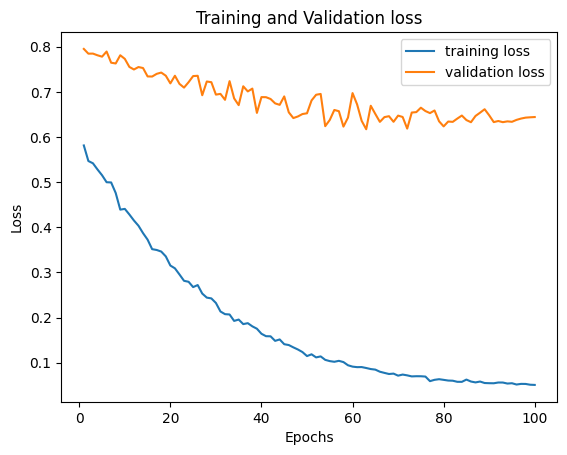

In [52]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()